# Estimação do Modelo Final
### Autor: Alexandre Saback

# Contextualização do Problema
Agora que a base de dados já foi devidamente explorada, assim como modelos iniciais, agora é o momento de tentar encontrar um modelo mais robusto que seja capaz de explicar de forma mais precisa as relações presentes nos dados.

# Instalação de Pacotes Adicionais

In [3]:
!pip install statstests
!pip install pyarrow

# Começando
O primeiro passo, mais uma vez, se concentra na importação dos pacotes necessários. A única adição aqui se concentra no _import_ do pacote _xgboost_, o qual possui modelos de _gradient boosting_ que serão utilizados nessa análise.

In [4]:
import pandas as pd
from statstests.tests import shapiro_francia
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Carregando os Dados

## Carregando o Objeto StandardScaler

In [6]:
with open('scaler.pickle', 'rb') as handle:
  scaler = pickle.load(handle)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Carregando o Dataset Pré-processado

In [8]:
dataset = pd.read_parquet("preprocessed_dataset.parquet", engine="pyarrow")

## Selecionando Variáveis Quantitativas e Qualitativas

In [9]:
quanti_features = ['QT_VENDA_BRUTO',
 'QT_DEVOLUCAO',
 'VL_RECEITA_BRUTA',
 'VL_RECEITA_LIQUIDA',
 'PCT_DESCONTO',
 'VL_PRECO']

# Definindo os Parâmetros Iniciais do Modelo

Como teste inicial, os parâmetros abaixo foram definidos de forma arbitrária apenas para produzir um resultado rápido e comparável.

In [41]:
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'alpha': 10,
    'n_estimators': 100
}

In [10]:
features = [feature for feature in list(dataset.columns) if feature != "VL_PRECO"]
features = [feature for feature in features if not feature.startswith("COD_MATERIAL")]

# Avaliando o Modelo Utilizando Todos os Dados

Como etapa inicial, decidi não separar os dados em Treino/Teste para realizar comparações fidedignas entre o modelo estimado e os modelos desenvolvidos na exploração anterior.

## Treinando o Modelo

In [42]:
dtrain = xgb.DMatrix(dataset[features], label=dataset["VL_PRECO"])

In [59]:
model = xgb.train(params, dtrain, num_boost_round=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [61]:
fitted_values = model.predict(dtrain)

## Valores Reais x Valores Estimados

In [46]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])
clean_df["fitted_values"] = fitted_values * clean_df["VL_PRECO"].std() + clean_df["VL_PRECO"].mean()

In [47]:
comparison_df = pd.DataFrame(data=[clean_df["VL_PRECO"].values, clean_df["fitted_values"]]).T
comparison_df.columns = ["true_values", "fitted_values"]

## Métricas de Erro

In [48]:
print(f"MSE: {mse(comparison_df['true_values'].values, comparison_df['fitted_values'])}")
print(f"MAE: {mae(comparison_df['true_values'].values, comparison_df['fitted_values'])}")

MSE: 3808.8656521074427
MAE: 32.720407211740536


Sem muito esforço, o modelo acima apresentou resultados melhores que os dois modelos estimados previamente, atingindo um MAE de 32.72 em comparação com 79.17 do modelo linear e 521.18 do modelo não linear, se tornando o melhor modelo até o momento.

## Feature Importance

Agora, vamos dar uma olhada na contribuição de algumas variáveis para a explicação da variável TARGET.

In [71]:
feature_importances = model.get_score(importance_type='weight')
total = sum(feature_importances.values())
normalized_importances = {k: v / total for k, v in feature_importances.items()}

features_df = pd.DataFrame({
    'Feature': normalized_importances.keys(),
    'Importance': normalized_importances.values()
})

features_df = features_df.sort_values(by='Importance', ascending=False)
top_20_features = features_df.iloc[:20]

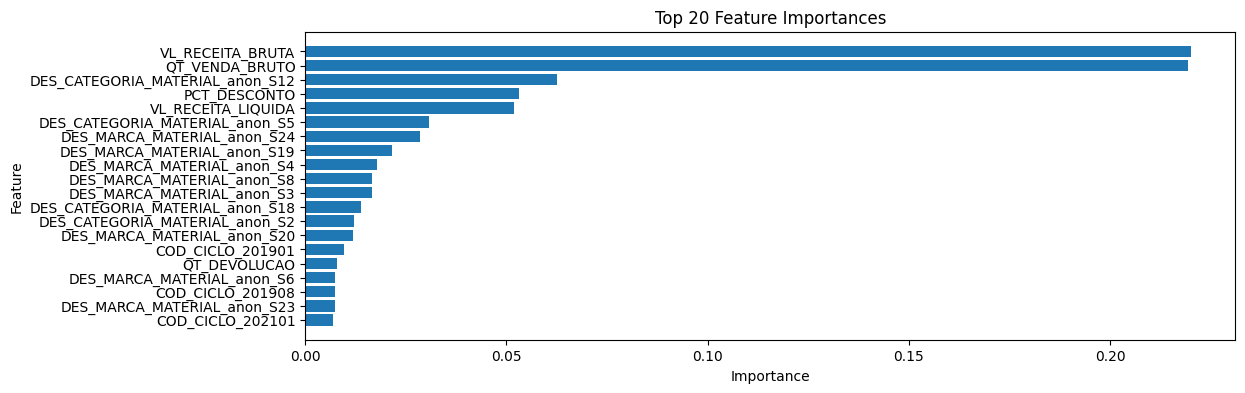

In [70]:
plt.figure(figsize=(12, 4))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()

De acordo como _plot_ acima, as variáveis `VL_RECEITA_BRUTA` e `QT_VENDA_BRUTO` contribuem fortemente para a explicação do comportamento da variável TARGET, representando cada uma cerca de 20% dos pesos atribuídos a cada variável.

O interessante é que essas variáveis, como analisado anteriormente, não apresentam uma correlação linear com a variável `VL_PRECO` (TARGET), mas mesmo assim contribuem fortemente para sua explicação de acordo com esse modelo.

# Dividindo os Dados em Treino/Teste

Agora, a ideia é dividir os dados em Treino/Teste para que seja possível realizar uma avaliação mais verdadeira do desempenho do modelo em dados não observados durante o treinamento (teste).

In [11]:
train_data = dataset[features]
target_variable = dataset["VL_PRECO"]

In [12]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(train_data, target_variable, test_size=0.3, random_state=42)

# Ajuste de Hiperparâmetros

Antes de realizar o treino do modelo, optei por realizar um GridSearch de forma rápida e concentrada para encontrar parâmetro que consigam explicar de forma mais precisa o comportamento observado nos dados.

In [13]:
# Definindo o espaço de busca dos parâmetros
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'alpha': [1, 10, 100]
}

In [14]:
# Definindo o modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [17]:
# Executando GridSearch
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [1, 10, 100],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=3)

De acordo com o método de GridSearch, o modelo com os melhores resultados, dentro dos critérios analisados, possui os parâmetros definidos abaixo.

In [19]:
print(f"Melhores Parâmetros: {grid_search.best_params_}")

Melhores Parâmetros: {'alpha': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 300}


In [20]:
# Reajustando o modelo com os melhores parâmetros
best_model = grid_search.best_estimator_

In [22]:
# Realizando predições
best_predictions = best_model.predict(X_test)

## Valores Reais x Valores Estimados - Base de Validação/Teste

Por fim, chegou o momento de avaliar o modelo no conjunto de teste. Os resultados obtidos aqui não são diretamente comparáveis com os resultados obtidos no modelo anterior, visto que, utilizei somente 70% da base de dados total para realizar o treinamento do modelo e estou avaliando sua performance em apenas 30% dos dados.

In [89]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])

comparison_df = pd.DataFrame()
comparison_df["true_values"] = y_test.values * clean_df["VL_PRECO"].std() + clean_df["VL_PRECO"].mean()
comparison_df["fitted_values"] = best_predictions * clean_df["VL_PRECO"].std() + clean_df["VL_PRECO"].mean()

## Métricas de Erro

In [90]:
print(f'MSE: {mse(comparison_df["true_values"], comparison_df["fitted_values"])}')
print(f'MAE: {mae(comparison_df["true_values"], comparison_df["fitted_values"])}')

MSE: 2064.4918391126234
MAE: 13.588206106487641


Embora não seja possível comparar de forma direta os dois modelos estimados nessa análise, é notório que o desempenho do modelo "tunado" apresenta melhores resultados em termos de métricas de erro.

## Feature Importance

In [34]:
feature_importances = best_model.feature_importances_

features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

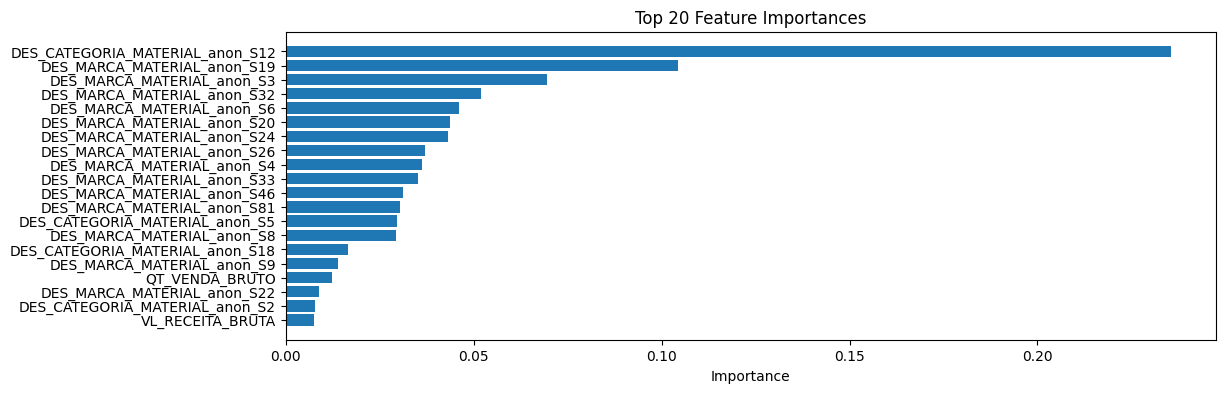

In [40]:
plt.figure(figsize=(12, 4))
plt.barh(features_df['Feature'].iloc[:20], features_df['Importance'].iloc[:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()

Diferente do modelo anterior, agora as categórias `anon_S12` e `anon_S19` respectivamente provenientes das variáveis `DES_CATEGORIA_MATERIAL` e `DES_MARCA_MATERIAL` são as que, de acordo com este modelo, possuem maior peso na estimativa da variável TARGET.

## Avaliando o Modelo Utilizando Todos os Dados
Por fim, apenas para fins comparativos com o modelo inicial, treinarei o modelo com os parâmetros "tunados" utilizando toda a base de dados disponível.

In [73]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    alpha= 1,
    learning_rate=0.3,
    max_depth=6,
    n_estimators=300)

In [76]:
xgb_fitted = xgb_model.fit(dataset[features], dataset["VL_PRECO"])

In [77]:
fitted_values_final = xgb_fitted.predict(dataset[features])

In [78]:
clean_df = dataset.copy()
clean_df[quanti_features] = scaler.inverse_transform(dataset[quanti_features])
clean_df["fitted_values"] = fitted_values_final * clean_df["VL_PRECO"].std() + clean_df["VL_PRECO"].mean()

In [79]:
comparison_df = pd.DataFrame(data=[clean_df["VL_PRECO"].values, clean_df["fitted_values"]]).T
comparison_df.columns = ["true_values", "fitted_values"]

## Métricas de Erro

In [88]:
print(f'MSE: {mse(comparison_df["true_values"], comparison_df["fitted_values"])}')
print(f'MAE: {mae(comparison_df["true_values"], comparison_df["fitted_values"])}')

MSE: 724.04558659406
MAE: 11.627375768563665


Agora, é possível compararmos de forma direta as métricas de erro entre os dois modelos estimados nessa análise. Tendo isso em vista, o modelo estimado utilizando GridSearch para "tunar" os parâmetros apresentou o melhor o resultado e, portanto, é o mais adequado para realizar predições no conjunto de dados em questão.

## Feature Importances

In [84]:
feature_importances = xgb_fitted.feature_importances_

features_df = pd.DataFrame({
    'Feature': dataset[features].columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

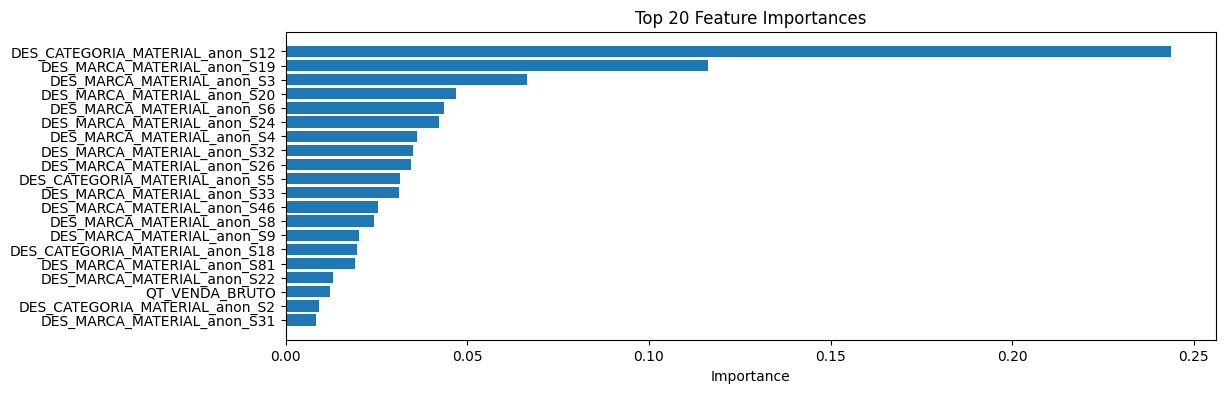

In [85]:
plt.figure(figsize=(12, 4))
plt.barh(features_df['Feature'].iloc[:20], features_df['Importance'].iloc[:20])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.show()

Devido a utilização de mais dados durante o treinamento, a ordem de importância de algumas variáveis foi alterada. No entanto, as duas variáveis mais influentes ainda são as mesmas.

# Conclusão
Tendo em vista tudo o que foi realizado e discutido nessa e análises prévias, o modelo mais adequado para a realização de previsão do valor do preço de um produto é o modelo XGBoost utilizando os parâmetros definidos através do GridSearch.

Abaixo ilustro uma tabela comparando os modelos desenvolvidos até então.

In [91]:
comparison_table = pd.DataFrame(columns=["modelo", "MSE", "MAE"])
comparison_table["modelo"] = ["OLS Linear", "OLS Não-Linear", "XGBoost Sem-Tuning", "XGBoost Tunado"]
comparison_table["MAE"] = [79.17, 521, 13.58, 11.62]
comparison_table["MSE"] = [19779, 334431, 3808, 724]

In [92]:
comparison_table

,modelo,MSE,MAE
0,OLS Linear,19779,79.17
1,OLS Não-Linear,334431,521.00
2,XGBoost Sem-Tuning,3808,13.58
3,XGBoost Tunado,724,11.62
